In [ ]:
import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
from platform import python_version
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np 
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from numpy import arange
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date
import random
from sklearn.metrics import make_scorer
today = str(date.today())

In [ ]:
random.seed(20)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
def run_models_FINAL(pos, save):
    
    print('Pulling data')

    metric_list = ['Avg','Sum']

    final_results = pd.DataFrame()
    prediction_results = pd.DataFrame()
    preds_2022_results = pd.DataFrame()
    for metric in metric_list:

      # Get cutoffs
      points_df = pd.read_csv("/content/gdrive/MyDrive/DVA Project/Data/player_plus_team.csv")
      if metric == 'Avg':
          points = points_df['Avg_PPRFantasyPoints']
          points_players = points_df.iloc[:, 1:5]
          points_players['y'] = points
      else:
          points = pd.read_csv("/content/gdrive/MyDrive/DVA Project/Data/player_plus_team.csv")
          points = points_df['Sum_PPRFantasyPoints']
          points_players = points_df.iloc[:, 1:5]
          points_players['y'] = points

      dict_12 = {}
      dict_24_36 = {}
      # dict_36 = {}
      year_list = points_players['Year'].unique()
      pos_list = ['RB','WR','TE','QB']

      for pos_loop in pos_list:
          list_12 = []
          list_24 = []
          list_36 = []
          for year in year_list:
          
              df = points_players.query(f"Year == {year} and Pos == '{pos_loop}'")
              df = df.sort_values('y', ascending=False)    
              top_12 = df.iloc[0:12, -1].min()
              top_24 = df.iloc[0:24, -1].min()
              top_36 = df.iloc[0:36, -1].min()
              list_12.append(top_12)
              list_24.append(top_24)
              list_36.append(top_36)
              
          avg_12 = np.mean(list_12)
          avg_24 = np.mean(list_24)
          avg_36 = np.mean(list_36)
          
          dict_12[pos_loop] = avg_12
          if pos_loop == 'RB' or pos_loop == 'WR':
            dict_24_36[pos_loop] = avg_36
          else:
            dict_24_36[pos_loop] = avg_24

      metric_clean = metric

      if metric == 'Avg':
          
          metric = 'Avg_Points'
          
          points_df = pd.read_csv("/content/gdrive/MyDrive/DVA Project/Data/player_plus_team.csv")
          points = points_df['Avg_PPRFantasyPoints']
          points_players = points_df.iloc[:, 1:5]
          points_players['Avg_Points'] = points
          
          # Read in Data
          data_original = pd.read_excel("/content/gdrive/MyDrive/DVA Project/Data/Pivoted_Data/pivoted_player_plus_team_data_ZEROS_Resp.xlsx")
          
          # Join with Data
          data_full = data_original.merge(points_players, left_on=['Player','Current_Year','Pos', 'Max_Team_Name'], right_on=['Player','Year','Pos', 'Team_Name'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
          data_full = data_full.drop(columns={'RESPONSE_Sum_PPRFantasyPoints', 'Team_Name', 'Year'}, axis=1)
          data_full = data_full[data_full['Pos'] == pos]

          cutoff_val_list = [0,4,6,9]
          
      
      else:
          metric_clean = 'Sum'
          metric = 'RESPONSE_Sum_PPRFantasyPoints'
          data_original = pd.read_excel("/content/gdrive/MyDrive/DVA Project/Data/Pivoted_Data/pivoted_player_plus_team_data_ZEROS_Resp.xlsx")
          
          data_full = data_original[data_original['Pos'] == pos]

          
          if pos == 'TE':
            cutoff_val_list = [0,50,100]
          else:
            cutoff_val_list = [0,50,100,150]


      pca_list = [True, False]
      boxcox_list = [True, False]
      cooks_list = [True, False]
      model_list = ['EN','RF']
      scorer_list = [True, False]
      one_year_list = [True, False]
          
          
      def my_custom_loss_func(y, y_hat):
      
          model_results = pd.DataFrame()
          model_results['y'] = y
          model_results['y_hat'] = y_hat

          # Rank
          model_results = model_results.sort_values('y', ascending=False)
          model_results['Rank'] = model_results.reset_index().index 
          model_results['Rank'] = model_results['Rank'] + 1
          model_results['Weight'] = 0
          model_results['Weight'].iloc[0:5] = 1
          model_results['Weight'].iloc[5:10] = 2
          model_results['Weight'].iloc[10:15] = 4
          model_results['Weight'].iloc[15:20] = 8
          model_results['Weight'].iloc[20:] = 16
          
          # NDCG Rank
          model_results['Diff'] = model_results['y'] - model_results['y_hat']
          model_results['Points_metric'] = model_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Weight'] + 1), axis=1)

          # Filter to create top and bottom
          bottom_cutoff = int(len(model_results)*.25)
          bottom = model_results.iloc[0:bottom_cutoff, :]

          rank = np.sum(bottom['Points_metric'])
          return rank


      scorer = make_scorer(my_custom_loss_func, greater_is_better=False)
      
      def top_50_df(model_results, top_50, test, pos, dict_12, dict_24_36):
          
          if test:
          
              model_results = model_results.sort_values('y',ascending=False)
              model_results['Rank'] = model_results.reset_index().index 
              model_results['Rank'] = model_results['Rank'] + 1
              model_results['Weight'] = 0
              model_results['Weight'].iloc[0:5] = 1
              model_results['Weight'].iloc[5:10] = 2
              model_results['Weight'].iloc[10:15] = 4
              model_results['Weight'].iloc[15:20] = 8
              model_results['Weight'].iloc[20:] = 16
              model_results = model_results.sort_values('y_hat',ascending=False)
              model_results['Rank_pred'] = model_results.reset_index().index 
              model_results['Rank_pred'] = model_results['Rank_pred'] + 1


              
              # join for Comparison
              top = model_results
              
              top = top[top['y'] > dict_12[pos]]
              top['Diff'] = top['Rank'] - top['Rank_pred']
              top = top.sort_values('y',ascending=False)
              top['rank_metric'] = top.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Weight'] + 1), axis=1)
              top['points_metric'] = top.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Weight'] + 1), axis=1)

              bottom  = model_results
              
              bottom = bottom[(bottom['y'] < dict_12[pos]) & (bottom['y'] > dict_24_36[pos])]
              bottom['Diff'] = bottom['Rank'] - bottom['Rank_pred']
              bottom = bottom.sort_values('y',ascending=False)
              bottom['rank_metric'] = bottom.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Weight'] + 1), axis=1)
              bottom['points_metric'] = bottom.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Weight'] + 1), axis=1)
              
              
              rank_top = np.sum(top['rank_metric'])
              median_top = np.median(top['rank_metric'])
              points_median_top = np.median(top['points_metric'])

              rank_bottom = np.sum(bottom['rank_metric'])
              median_bottom = np.median(bottom['rank_metric'])
              points_median_bottom = np.median(bottom['points_metric'])

              test_MAPE_20 = mean_absolute_percentage_error(top['y'], top['y_hat'])
              test_MAPE_50 = mean_absolute_percentage_error(bottom['y'], bottom['y_hat'])
              test_MAPE_FULL = mean_absolute_percentage_error(model_results['y'], model_results['y_hat'])


              
              return rank_top, test_MAPE_20, points_median_top, rank_bottom, test_MAPE_50, points_median_bottom
          
          else: 
      
              model_results = model_results.sort_values('y',ascending=False)
              model_results['Weight'] = 0
              model_results['Weight'].iloc[0:5] = 1
              model_results['Weight'].iloc[5:10] = 2
              model_results['Weight'].iloc[10:15] = 4
              model_results['Weight'].iloc[15:20] = 8
              model_results['Weight'].iloc[20:] = 16
              model_results = model_results.sort_values('y_hat',ascending=False)
              model_results['Rank_pred'] = model_results.reset_index().index 
              model_results['Rank_pred'] = model_results['Rank_pred'] + 1
              
              
              
              # join for Comparison
              joined_results = model_results.merge(top_50, left_on=['Player','Max_Team_Name','Pos','Current_Year'], right_on=['Player','Max_Team_Name','Pos','Current_Year'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
              joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
              joined_results = joined_results.sort_values('y',ascending=False)
              joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Weight'] + 1), axis=1)
              joined_results['points_metric'] = joined_results.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Weight'] + 1), axis=1)
    

              if pos == 'QB' or pos == 'TE':
                
                filtered_results = joined_results.iloc[0:12, :]
                bottom = joined_results.iloc[12:24,:]
              else:
                filtered_results = joined_results.iloc[0:12, :]
                bottom = joined_results.iloc[12:36,:]


              
              rank_20 = np.sum(filtered_results['rank_metric'])
              rank_median_20 = np.median(filtered_results['rank_metric'])
              points_rank_20 = np.sum(filtered_results['points_metric'])
              points_median_20 = np.median(filtered_results['points_metric'])

              rank_50 = np.sum(bottom['rank_metric'])
              rank_median_50 = np.median(bottom['rank_metric'])
              points_rank_50 = np.sum(bottom['points_metric'])
              points_median_50 = np.median(bottom['points_metric'])

              MAPE_20 = mean_absolute_percentage_error(filtered_results['y'], filtered_results['y_hat'])
              MAPE_50 = mean_absolute_percentage_error(bottom['y'], bottom['y_hat'])
              MAPE_FULL = mean_absolute_percentage_error(joined_results['y'], joined_results['y_hat'])

              return joined_results, rank_50, MAPE_50, points_rank_50, points_median_50, rank_20, MAPE_20, points_rank_20, points_median_20
              
      
      
      print('Running Models')
      
      # Loop
      for cutoff_val in cutoff_val_list:
        for pca_val in pca_list:
            for boxcox_val in boxcox_list:
                for cooks_val in cooks_list:
                  for model in model_list:
                    for use_scorer in scorer_list:
                      for one_year in one_year_list:

                        

                        if one_year == True:
                          temp_data = data_full[data_full.columns.drop(list(data_full.filter(regex='- 2')))]
                          temp_data = temp_data[temp_data.columns.drop(list(temp_data.filter(regex='- 3')))]

                        else:
                          temp_data = data_full


                        # Val Set
                        val_set = temp_data[temp_data['Current_Year'] == 2021]
                        pred_set = temp_data[temp_data['Current_Year'] == 2022]

                        model_data = temp_data[temp_data[metric] > cutoff_val]
                        model_data = model_data[model_data['Current_Year'] < 2021]
                        model_data = model_data[model_data['Current_Year'] >= 2011]
                        
                        
                        
                        # RB Modeling
                        data = model_data.copy()
                        
                        
                        
                        if boxcox_val == True:
                          # Boxcox transformation
                          transformed_data, best_lambda = boxcox(data[metric]) 

                          # Replace Y with transformed data
                          data['y'] = transformed_data
                        else:
                          data['y'] = data[metric]
                        
                        
                        data = data.drop(columns=str(metric), axis=1)
                        
                        # Split into Train and Test
                        x_players = data.iloc[:, 0:4]
                        x_data = data.iloc[:, 4:-1]
                        y_data = data.iloc[:, -1]
                        
                        # Fill NA with 0
                        x_data = x_data.fillna(0)
                            
                        # Split Train Test
                        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=614, shuffle=True)
                        
                        # Undo ytest lambda
                        if boxcox_val == True:
                          y_test = inv_boxcox(y_test, best_lambda)
                        
                        # If Cooks
                        if cooks_val == True:
                          visualizer = CooksDistance()
                          visualizer.fit(x_train, y_train)
                          #visualizer.show()
                          i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
                          x_train, y_train = x_train[i_less_influential], y_train[i_less_influential]
                        
                        # Scale data
                        scaler = StandardScaler() 
                        x_train = scaler.fit_transform(x_train)
                        x_test = scaler.transform(x_test)
                        
                        # Val Data
                        val_players = val_set.iloc[:, 0:4]
                        val_x = val_set.iloc[:, 4:-1]
                        val_x = val_x.fillna(0)
                        val_y = val_set.iloc[:, -1]

                        # Prediction Data

                        pred_players = pred_set.iloc[:, 0:4]
                        pred_x = pred_set.iloc[:, 4:-1]
                        pred_x = pred_x.fillna(0)
                        pred_y = pred_set.iloc[:, -1]
                        
                        # Scale val_x
                        val_x = scaler.transform(val_x)
                        pred_x = scaler.transform(pred_x)
                        
                        # If PCA
                        if pca_val == True:
                          pca = PCA(n_components = 15)
                          x_train = pca.fit_transform(x_train)
                          x_test = pca.transform(x_test)
                          val_x = pca.transform(val_x)
                          pred_x = pca.transform(pred_x)
                        
                        
                        
                        # Try  with CV
                        folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
                        
                        # Pull out top 50
                        top_50 = pd.DataFrame(val_players)
                        top_50['cutoff_val'] = cutoff_val
                        top_50['y'] = val_y
                        top_50 = top_50.sort_values('y',ascending=False).iloc[0:50,:]
                        top_50['Rank'] = top_50.reset_index().index
                        top_50['Rank'] = top_50['Rank'] + 1

                        
                        
                        try:
                          # define model

                          if model == 'EN':
                            EN = ElasticNet(random_state = 420)
                            # define model evaluation method (used same folds as above for first pass)
 
                            # define grid
                            EN_grid = dict()
                            EN_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                            EN_grid['l1_ratio'] = arange(0, 1, 0.01)
                            # define search
                            if use_scorer == True:
                              EN_search = GridSearchCV(EN, EN_grid, scoring=scorer, cv=folds, n_jobs=-1)
                            else:
                              EN_search = GridSearchCV(EN, EN_grid, scoring='neg_mean_absolute_percentage_error', cv=folds, n_jobs=-1)

                            # perform the search
                            EN_results = EN_search.fit(x_train, y_train)

                          else:
                            random_grid = {'n_estimators': [100, 200, 500],
                              'max_features': ['auto', 'sqrt'],
                              'max_depth' : [4,5,6,7,8]}
                      
                      
                            rf = RandomForestRegressor(random_state=420)
                            
                            # define search
                            if use_scorer == True:
                              rf_cv = GridSearchCV(estimator=rf, 
                                                  param_grid=random_grid,
                                                  cv = folds,
                                                  scoring=scorer, 
                                                  n_jobs=-1)
                            else:
                              rf_cv = GridSearchCV(estimator=rf, 
                                                  param_grid=random_grid,
                                                  cv = folds,
                                                  scoring='neg_mean_absolute_percentage_error', 
                                                  n_jobs=-1)
                            # perform the search
                            EN_results = rf_cv.fit(x_train, y_train)
                          
                          rf_val_pred = EN_results.predict(val_x)
                          rf_test_pred = EN_results.predict(x_test)
                          rf_pred_pred = EN_results.predict(pred_x)
                          if boxcox_val == True:
                            rf_val_pred = inv_boxcox(rf_val_pred, best_lambda)
                            rf_test_pred = inv_boxcox(rf_test_pred, best_lambda)
                            rf_pred_pred = inv_boxcox(rf_pred_pred, best_lambda)
                          
                          rf_results = pd.DataFrame(val_players)
                          rf_results['Metric'] = metric_clean
                          rf_results['Cooks'] = cooks_val
                          rf_results['Boxcox'] = boxcox_val
                          rf_results['PCA'] = pca_val
                          rf_results['Model'] = model
                          rf_results['Scoring'] = use_scorer
                          rf_results['One_Year'] = one_year
                          rf_results['cutoff_val'] = cutoff_val
                          rf_results['y'] = val_y
                          rf_results['y_hat'] = rf_val_pred
                          rf_results = rf_results[rf_results['y_hat'] > 0]
                          rf_results = rf_results[rf_results['y'] > 0].sort_values('y', ascending=False)
                          rf_results = rf_results.iloc[0:50,:]
                          
                          rf_results_joined, rank_50, MAPE_50, points_rank_50, points_median_50, rank_20, MAPE_20, points_rank_20, points_median_20 = top_50_df(rf_results, top_50, False, pos, dict_12, dict_24_36)


                          # Predictions
                          EN_results = pd.DataFrame(pred_players)
                          EN_results['Metric'] = metric_clean
                          EN_results['Cooks'] = cooks_val
                          EN_results['Boxcox'] = boxcox_val
                          EN_results['PCA'] = pca_val
                          EN_results['Model'] = model
                          EN_results['Scoring'] = use_scorer
                          EN_results['One_Year'] = one_year
                          EN_results['cutoff_val'] = cutoff_val
                          EN_results['y_hat'] = rf_pred_pred


                          # Test MSE
                          
                          test_df = pd.DataFrame()

                          test_df['y'] = y_test
                          test_df['y_hat'] = rf_test_pred
                          test_df = test_df.sort_values('y',ascending=False)
                          test_df = test_df[test_df['y'] > 0]
                          test_df = test_df[test_df['y_hat'] > 0]


                          test_rank_top, test_MAPE_20, test_points_median_top, test_rank_bottom, test_MAPE_50, test_points_median_bottom = top_50_df(test_df, top_50, True, pos, dict_12, dict_24_36)
                          #rf_test_rank, rf_test_median, rf_test_points_median = top_50_df(test_df, top_50, True)


                          RF_data = pd.DataFrame(data=[[metric_clean, cooks_val, boxcox_val, pca_val, cutoff_val, model, one_year, use_scorer, rank_50, MAPE_50, points_rank_50, points_median_50, rank_20, MAPE_20, points_rank_20, points_median_20, test_rank_top, test_MAPE_20, test_points_median_top, test_rank_bottom, test_MAPE_50, test_points_median_bottom]] \
                                                , columns = ['Metric','Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model', 'Year1Only', 'Custom_Scorer', 'rank_50', 'MAPE_50', 'points_rank_50','points_median_50', 'rank_20', 'MAPE_20','points_rank_20','points_median_20', 'test_rank_top', 'test_MAPE_20', 'test_points_median_top', 'test_rank_bottom', 'test_MAPE_50', 'test_points_median_bottom'])
                          final_results = pd.concat([final_results, RF_data])
                          prediction_results = pd.concat([prediction_results, rf_results_joined])

                          preds_2022_results = pd.concat([preds_2022_results, EN_results])
                        except:
                          print('Metric, cutoff, pca, boxcox, cooks, model, scorer, one_year')
                          print(metric_clean, cutoff_val, pca_val, boxcox_val, cooks_val, model, use_scorer, one_year)
                          pass

    #return final_results, prediction_results
    if save == True:
        print('Saving Models')
        # Save outputs
        final_results.to_excel('/content/gdrive/MyDrive/DVA Project/Data/Predictions/Raw_Predictions/{}_model_results_{}.xlsx'.format(pos, today))

        prediction_results.to_excel('/content/gdrive/MyDrive/DVA Project/Data/Predictions/Raw_Predictions/2021_{}_predictions_{}.xlsx'.format(pos,today))

        preds_2022_results.to_excel('/content/gdrive/MyDrive/DVA Project/Data/Predictions/Raw_Predictions/2022_{}_predictions_{}.xlsx'.format(pos, today))
                

In [ ]:
run_models_FINAL(pos='QB',save=True)


Pulling data
Running Models
Running Models
Saving Models


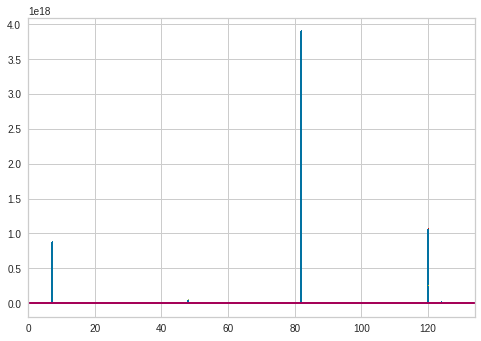

In [ ]:
run_models_FINAL(pos='RB',save=True)

Pulling data
Running Models
Running Models
Saving Models


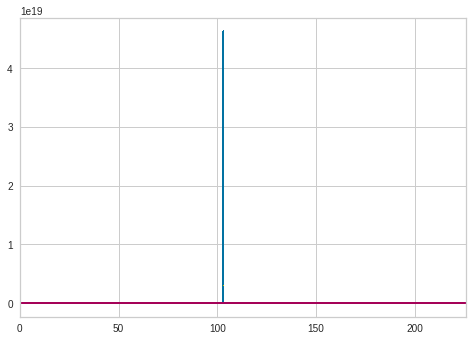

In [ ]:
run_models_FINAL(pos='WR',save=True)

Pulling data
Running Models
Running Models
Saving Models


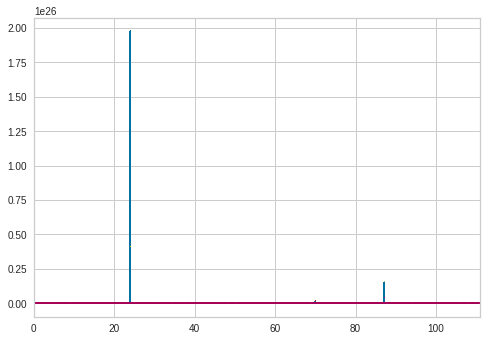

In [ ]:
run_models_FINAL(pos='TE',save=True)

# Below is optional:
## Use pred_rankings to further analyze prediction results

In [ ]:
def pred_rankings(pos):

  pos = pos
  try:
    df = pd.read_excel('/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/Optimizing_Points/EN_Testing/Model_Comparisons/2021_{}_predictions_2022-04-12.xlsx'.format(pos))
  except:
    df = pd.read_excel('/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/Optimizing_Points/EN_Testing/Model_Comparisons/2021_{}_predictions_2022-04-11.xlsx'.format(pos))
  df = df.sort_values('Rank_pred',ascending=True)


  output_df = pd.DataFrame()
  # Loop through
  metric_list = ['Avg','Sum']
  #cutoff_val_list = [4,6,9,50,100,50]
  pca_list = [True, False]
  boxcox_list = [True, False]
  cooks_list = [True, False]
  model_list = ['EN','RF']
  scorer_list =[True, False]
  one_year_list = [True, False]

  for metric in metric_list:
    if metric == 'Avg':
      cutoff_val_list = [0,4,6,9]
    else:
        cutoff_val_list = [0,50,100,150]
    for cutoff_val in cutoff_val_list:
      for pca_val in pca_list:
        for boxcox_val in boxcox_list:
            for cooks_val in cooks_list:
              for model in model_list:
                for use_scorer in scorer_list:
                  for one_year in one_year_list:
                    if model == 'EN':

                      df_temp = df[(df['Model'] == 'EN') & (df['Metric'] == metric)]
                      df_temp = df_temp.query(f"cutoff_val == {cutoff_val} and PCA == {pca_val} and Boxcox == {boxcox_val} and Cooks == {cooks_val} and  Scoring == {use_scorer} and One_Year == {one_year} ")

                      top = df_temp.iloc[0:12]
                      top_mean = np.mean(abs(top['Diff']))
                      top_sum = np.sum(abs(top['Diff']))
                      top_median = np.median(abs(top['Diff']))
                      top_count = (top['Rank'] <= 12).sum() * -1

                      bottom = df_temp.iloc[12:36]
                      bottom_mean = np.mean(abs(bottom['Diff']))
                      bottom_sum = np.sum(abs(bottom['Diff']))
                      bottom_median = np.median(abs(bottom['Diff']))
                      bottom_count = (bottom['Rank'] <= 24).sum() * -1
                    

                      temp_df = pd.DataFrame([[metric, cutoff_val,cooks_val, boxcox_val, pca_val,  model, use_scorer, one_year, top_mean, top_sum, top_median, top_count, bottom_mean, bottom_sum, bottom_median, bottom_count]], \
                                            columns = ['metric', 'cutoff_val', 'cooks_val',  'boxcox_val', 'pca_val','model', 'use_scorer', 'one_year', 'top_mean', 'top_sum','top_median','top_count','bottom_mean', 'bottom_sum','bottom_median','bottom_count'])

                      output_df = pd.concat([output_df, temp_df])

                    else:
                      df_temp = df[(df['Model'] == 'RF') & (df['Metric'] == metric)]
                      df_temp = df_temp.query(f"cutoff_val == {cutoff_val} and PCA == {pca_val} and Boxcox == {boxcox_val} and Cooks == {cooks_val} and Scoring == {use_scorer} and One_Year == {one_year} ")

                      top = df_temp.iloc[0:12]
                      top_mean = np.mean(abs(top['Diff']))
                      top_sum = np.sum(abs(top['Diff']))
                      top_median = np.median(abs(top['Diff']))
                      top_count = (top['Rank'] <= 12).sum() * -1

                      bottom = df_temp.iloc[12:36]
                      bottom_mean = np.mean(abs(bottom['Diff']))
                      bottom_sum = np.sum(abs(bottom['Diff']))
                      bottom_median = np.median(abs(bottom['Diff']))
                      bottom_count = (bottom['Rank'] <= 24).sum() * -1

                      temp_df = pd.DataFrame([[metric, cutoff_val,cooks_val, boxcox_val, pca_val,  model, use_scorer, one_year, top_mean, top_sum, top_median, top_count, bottom_mean, bottom_sum, bottom_median, bottom_count]], \
                                            columns = ['metric', 'cutoff_val', 'cooks_val',  'boxcox_val', 'pca_val','model', 'use_scorer', 'one_year', 'top_mean', 'top_sum','top_median','top_count','bottom_mean', 'bottom_sum','bottom_median','bottom_count'])
                      output_df = pd.concat([output_df, temp_df])


  return output_df

In [ ]:
wr_output = pred_rankings('WR')

In [ ]:
rb_output = pred_rankings('RB')

In [ ]:
rb_output

In [ ]:
qb_output = pred_rankings('QB')

In [ ]:
qb_output